## **Main_VGG16**


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#setting some constraints/variables
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224
BATCH_SIZE = 4
NUM_EPOCHS = 5
NUM_CLASSES = 2

In [ ]:
#file path for the dataset
train_data_dir = '/content/drive/MyDrive/chest_xray/train'
validation_data_dir = '/content/drive/MyDrive/chest_xray/test'
# the test set in the folder is actually used as the validation dataset and val set in the drive used as test dataset

In [ ]:
#data preparation
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#altering the model according to personal use-case
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(NUM_CLASSES, activation = 'softmax'))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21137986 (80.64 MB)
Trainable params: 6423298 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
#trainning the model
model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // BATCH_SIZE,
    epochs = NUM_EPOCHS,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // BATCH_SIZE
)

model.save('pneumonia_detection_model_vgg16.h5')

Epoch 1/5
1304/1304 [==============================] - 4054s 3s/step - loss: 1.7071 - accuracy: 0.9335 - val_loss: 0.6473 - val_accuracy: 0.7837
Epoch 2/5
1221/1304 [===========================>..] - ETA: 3:33 - loss: 0.1145 - accuracy: 0.9609

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('pneumonia_detection_model_vgg16.h5')

In [ ]:
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    return img_preprocessed

image_path = '/content/drive/MyDrive/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg'

preprocessed_image = preprocess_image(image_path)

prediction = model.predict(preprocessed_image)

class_label = np.argmax(prediction) #(0: 'Normal', 1: 'Pneumonia')

class_prob = prediction[0][class_label]

if class_label == 0:
    print("Predicted class: Normal")
else:
    print("Predicted class: Pneumonia")

print("Predicted probability: {:.2f}%".format(class_prob * 100))


1/1 [==============================] - 2s 2s/step
Predicted class: Pneumonia
Predicted probability: 98.30%


In [ ]:
#testing the model and analysing its accuracy and perfomance
from sklearn.metrics import classification_report, confusion_matrix

validation_steps = validation_generator.n // BATCH_SIZE
y_true = []
y_pred = []

for i in range(validation_steps):
    x_val, y_val = validation_generator.next()
    y_true.extend(np.argmax(y_val, axis = 1))
    y_pred.extend(np.argmax(model.predict(x_val), axis = 1))

confusion_mat = confusion_matrix(y_true, y_pred)
classification_rep = classification_report(y_true, y_pred, target_names = ['Normal', 'Pneumonia'])

print("Confusion Matrix:")
print(confusion_mat)

print("\nClassification Report:")
print(classification_rep)


1/1 [==============================] - 0s 19ms/step
Confusion Matrix:
[[190  44]
 [ 17 373]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.92      0.81      0.86       234
   Pneumonia       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



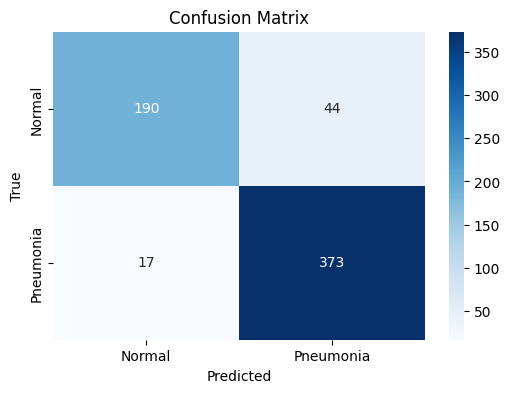

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plot

class_labels = ['Normal', 'Pneumonia']

plot.figure(figsize = (6, 4))
sns.heatmap(confusion_mat, annot = True, fmt='d', cmap='Blues', xticklabels = class_labels, yticklabels=class_labels)

plot.xlabel('Predicted')
plot.ylabel('True')
plot.title('Confusion Matrix')
plot.xticks(np.arange(NUM_CLASSES) + 0.5, class_labels)
plot.yticks(np.arange(NUM_CLASSES) + 0.5, class_labels)

plot.show()

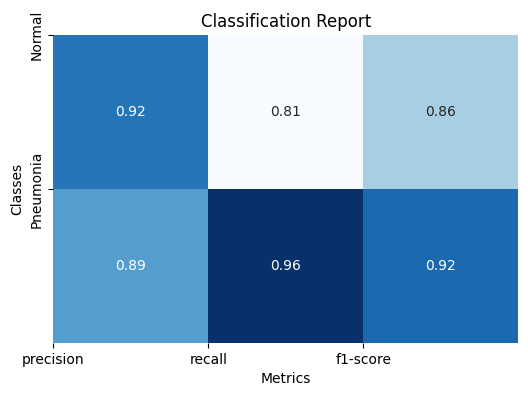

In [ ]:
report = classification_report(y_true, y_pred, target_names = ['Normal', 'Pneumonia'], output_dict = True)

metrics = ['precision', 'recall', 'f1-score']
heatmap_data = []
for label in class_labels:
    heatmap_data.append([report[label][metric] for metric in metrics])

plot.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot = True, cmap = 'Blues', fmt = '.2f', cbar = False)

plot.xlabel('Metrics')
plot.ylabel('Classes')
plot.title('Classification Report')
plot.xticks(np.arange(len(metrics)), metrics)
plot.yticks(np.arange(NUM_CLASSES), class_labels)

plot.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Main_VGG19**


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224
BATCH_SIZE = 4
NUM_EPOCHS = 5
NUM_CLASSES = 2

In [ ]:
train_data_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/train'
validation_data_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/test' #the test set in the folder is actually used as the validation dataset and val set in the drive used as test dataset

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 5217 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
base_model = VGG19(weights = 'imagenet', include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(NUM_CLASSES, activation = 'softmax'))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // BATCH_SIZE,
    epochs = NUM_EPOCHS,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // BATCH_SIZE
)

model.save('pneumonia_detection_model_vgg19.h5')

Epoch 1/5
1304/1304 [==============================] - 156s 117ms/step - loss: 1.1933 - accuracy: 0.9279 - val_loss: 0.3076 - val_accuracy: 0.8910
Epoch 2/5
1304/1304 [==============================] - 145s 111ms/step - loss: 0.1200 - accuracy: 0.9620 - val_loss: 0.2315 - val_accuracy: 0.9343
Epoch 3/5
1304/1304 [==============================] - 146s 112ms/step - loss: 0.0891 - accuracy: 0.9708 - val_loss: 0.3767 - val_accuracy: 0.9038
Epoch 4/5
1304/1304 [==============================] - 147s 113ms/step - loss: 0.0919 - accuracy: 0.9682 - val_loss: 0.6915 - val_accuracy: 0.8766
Epoch 5/5
1304/1304 [==============================] - 144s 110ms/step - loss: 0.0816 - accuracy: 0.9716 - val_loss: 0.6899 - val_accuracy: 0.8942


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('pneumonia_detection_model_vgg19.h5')

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    return img_preprocessed

image_path = '/content/drive/MyDrive/Colab Notebooks/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg'

preprocessed_image = preprocess_image(image_path)

prediction = model.predict(preprocessed_image)

class_label = np.argmax(prediction) #(0: 'Normal', 1: 'Pneumonia')

class_prob = prediction[0][class_label]

if class_label == 0:
    print("Predicted class: Normal")
else:
    print("Predicted class: Pneumonia")

print("Predicted probability: {:.2f}%".format(class_prob * 100))


1/1 [==============================] - 0s 269ms/step
Predicted class: Pneumonia
Predicted probability: 100.00%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

validation_steps = validation_generator.n // BATCH_SIZE
y_true = []
y_pred = []

for i in range(validation_steps):
    x_val, y_val = validation_generator.next()
    y_true.extend(np.argmax(y_val, axis=1))
    y_pred.extend(np.argmax(model.predict(x_val), axis=1))

confusion_mat = confusion_matrix(y_true, y_pred)
classification_rep = classification_report(y_true, y_pred, target_names = ['Normal', 'Pneumonia'])

print("Confusion Matrix:")
print(confusion_mat)

print("\nClassification Report:")
print(classification_rep)


1/1 [==============================] - 0s 29ms/step
Confusion Matrix:
[[173  61]
 [  5 385]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.74      0.84       234
   Pneumonia       0.86      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.92      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624



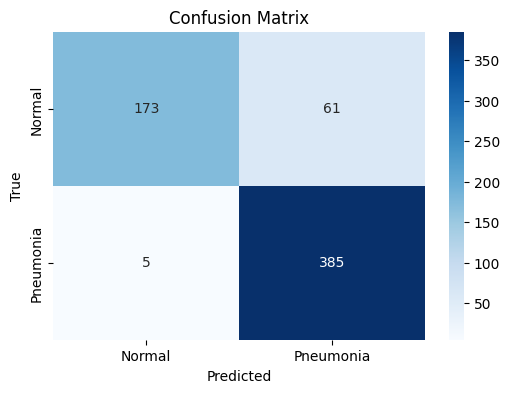

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plot
class_labels = ['Normal', 'Pneumonia']

plot.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_labels, yticklabels = class_labels)

plot.xlabel('Predicted')
plot.ylabel('True')
plot.title('Confusion Matrix')
plot.xticks(np.arange(NUM_CLASSES) + 0.5, class_labels)
plot.yticks(np.arange(NUM_CLASSES) + 0.5, class_labels)

plot.show()

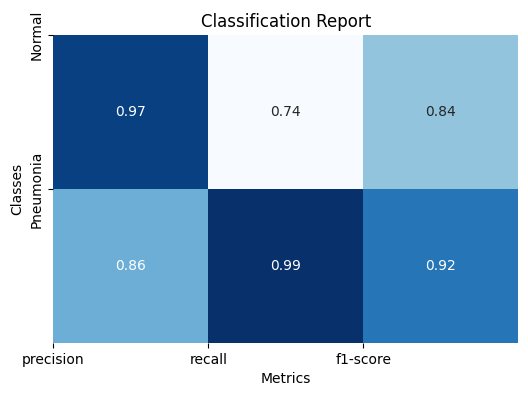

In [ ]:
import pandas as pd

report = classification_report(y_true, y_pred, target_names = ['Normal', 'Pneumonia'], output_dict = True)

metrics = ['precision', 'recall', 'f1-score']
heatmap_data = []
for label in class_labels:
    heatmap_data.append([report[label][metric] for metric in metrics])

plot.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='.2f', cbar=False)

plot.xlabel('Metrics')
plot.ylabel('Classes')
plot.title('Classification Report')
plot.xticks(np.arange(len(metrics)), metrics)
plot.yticks(np.arange(NUM_CLASSES), class_labels)

plot.show()

## **Main_ResNet-50**


In [ ]:
import numpy as np
import matplotlib.pyplot as plot
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224
BATCH_SIZE = 4
NUM_EPOCHS = 5
NUM_CLASSES = 2

In [ ]:
train_data_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/train'
validation_data_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/test'  #the test set in the folder is actually used as the validation dataset and val set in the drive used as test dataset

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 5217 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
base_model = ResNet50(weights='imagenet', include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(NUM_CLASSES, activation = 'softmax'))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 49278594 (187.98 MB)
Trainable params: 25690882 (98.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // BATCH_SIZE,
    epochs = NUM_EPOCHS,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // BATCH_SIZE
)

model.save('pneumonia_detection_model_resnet50.h5')

Epoch 1/5
1304/1304 [==============================] - 1170s 892ms/step - loss: 2.4622 - accuracy: 0.9398 - val_loss: 0.3026 - val_accuracy: 0.9199
Epoch 2/5
1304/1304 [==============================] - 148s 113ms/step - loss: 0.1194 - accuracy: 0.9649 - val_loss: 0.3860 - val_accuracy: 0.9087
Epoch 3/5
1304/1304 [==============================] - 149s 114ms/step - loss: 0.1059 - accuracy: 0.9680 - val_loss: 0.4886 - val_accuracy: 0.8686
Epoch 4/5
1304/1304 [==============================] - 145s 111ms/step - loss: 0.0976 - accuracy: 0.9691 - val_loss: 0.7106 - val_accuracy: 0.8798
Epoch 5/5
1304/1304 [==============================] - 147s 112ms/step - loss: 0.0853 - accuracy: 0.9724 - val_loss: 0.4179 - val_accuracy: 0.9038


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('pneumonia_detection_model_resnet50.h5')

In [ ]:
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    return img_preprocessed

image_path = '/content/drive/MyDrive/Colab Notebooks/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg'

preprocessed_image = preprocess_image(image_path)

prediction = model.predict(preprocessed_image)

class_label = np.argmax(prediction) #(0: 'Normal', 1: 'Pneumonia') #returns index having the greatest element value

class_prob = prediction[0][class_label]

if class_label == 0:
    print("Predicted class: Normal")
else:
    print("Predicted class: Pneumonia")

print("Predicted probability: {:.2f}%".format(class_prob * 100))


1/1 [==============================] - 1s 1s/step
Predicted class: Pneumonia
Predicted probability: 100.00%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

validation_steps = validation_generator.n // BATCH_SIZE
y_true = []
y_pred = []

for i in range(validation_steps):
    x_val, y_val = validation_generator.next()
    y_true.extend(np.argmax(y_val, axis = 1))
    y_pred.extend(np.argmax(model.predict(x_val), axis = 1))

confusion_mat = confusion_matrix(y_true, y_pred)
classification_rep = classification_report(y_true, y_pred, target_names = ['Normal', 'Pneumonia'])

print("Confusion Matrix:")
print(confusion_mat)

print("\nClassification Report:")
print(classification_rep)


1/1 [==============================] - 0s 38ms/step
Confusion Matrix:
[[181  53]
 [  7 383]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.77      0.86       234
   Pneumonia       0.88      0.98      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624



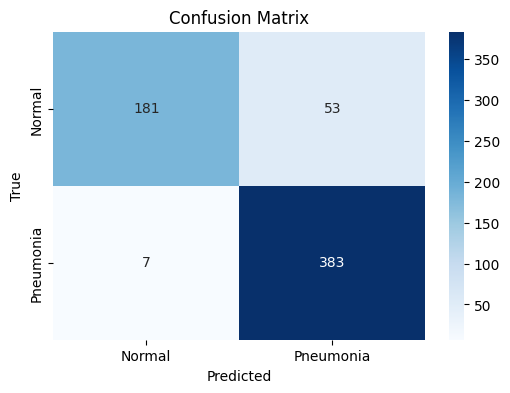

In [ ]:
import seaborn as sns
class_labels = ['Normal', 'Pneumonia']

plot.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot = True, fmt='d', cmap='Blues', xticklabels = class_labels, yticklabels=class_labels)

plot.xlabel('Predicted')
plot.ylabel('True')
plot.title('Confusion Matrix')
plot.xticks(np.arange(NUM_CLASSES) + 0.5, class_labels)
plot.yticks(np.arange(NUM_CLASSES) + 0.5, class_labels)

plot.show()

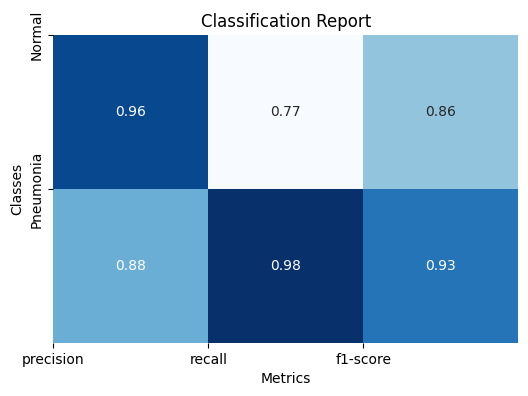

In [ ]:
import pandas as pd

report = classification_report(y_true, y_pred, target_names = ['Normal', 'Pneumonia'], output_dict = True)

metrics = ['precision', 'recall', 'f1-score']
heatmap_data = []
for label in class_labels:
    heatmap_data.append([report[label][metric] for metric in metrics])

plot.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='.2f', cbar=False)

plot.xlabel('Metrics')
plot.ylabel('Classes')
plot.title('Classification Report')
plot.xticks(np.arange(len(metrics)), metrics)
plot.yticks(np.arange(NUM_CLASSES), class_labels)

plot.show()

# Main_CondenseNet


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224
BATCH_SIZE = 4
NUM_EPOCHS = 5
NUM_CLASSES = 2

In [ ]:
train_data_dir = '/content/drive/MyDrive/chest_xray/train'
validation_data_dir = '/content/drive/MyDrive/chest_xray/test'  #the test set in the folder is actually used as the validation dataset and val set in the drive used as test dataset

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
def dense_block(input_tensor, growth_rate, num_layers):
    for i in range(num_layers):
        x = BatchNormalization()(input_tensor)
        x = Activation('relu')(x)
        x = Conv2D(growth_rate, kernel_size=(3,3), padding='same')(x)
        input_tensor = Concatenate()([input_tensor, x])
    return input_tensor


def transition_layer(input_tensor, compression_factor):
    num_channels = int(input_tensor.shape[-1])
    num_channels = int(num_channels * compression_factor)
    x = BatchNormalization()(input_tensor)
    x = Conv2D(num_channels, kernel_size=(1,1), padding='same')(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    return x

def CondenseNet(input_shape, growth_rate=12, compression_factor=0.5, num_blocks=[6, 12, 24, 16], num_classes=2):
    input_tensor = Input(shape=input_shape)
    x = Conv2D(2 * growth_rate, kernel_size=(7,7), padding='same', strides=(2,2))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)

    num_filters = 2 * growth_rate
    for i, num_layers in enumerate(num_blocks):
        x = dense_block(x, growth_rate, num_layers)
        if i != len(num_blocks) - 1:
            x = transition_layer(x, compression_factor)
            num_filters = int(num_filters * compression_factor)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(input_tensor, x)
    return model

In [ ]:
input_shape = (224, 224, 3)
model = CondenseNet(input_shape)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 24)         3552      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 24)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 112, 112, 24)         0         ['batch_normalization[0][0

In [ ]:
model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // BATCH_SIZE,
    epochs = NUM_EPOCHS,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // BATCH_SIZE
)

model.save('pneumonia_detection_model_condense.h5')

Epoch 1/5
1304/1304 [==============================] - 1325s 978ms/step - loss: 0.3517 - accuracy: 0.8493 - val_loss: 1.4889 - val_accuracy: 0.5465
Epoch 2/5
1304/1304 [==============================] - 170s 130ms/step - loss: 0.2647 - accuracy: 0.8940 - val_loss: 1.1693 - val_accuracy: 0.7228
Epoch 3/5
1304/1304 [==============================] - 167s 128ms/step - loss: 0.2268 - accuracy: 0.9126 - val_loss: 0.8481 - val_accuracy: 0.7179
Epoch 4/5
1304/1304 [==============================] - 172s 132ms/step - loss: 0.2020 - accuracy: 0.9199 - val_loss: 3.4844 - val_accuracy: 0.6250
Epoch 5/5
1304/1304 [==============================] - 171s 131ms/step - loss: 0.1835 - accuracy: 0.9302 - val_loss: 0.7754 - val_accuracy: 0.7340


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

validation_steps = validation_generator.n // BATCH_SIZE
y_true = []
y_pred = []

for i in range(validation_steps):
    x_val, y_val = validation_generator.next()
    y_true.extend(np.argmax(y_val, axis = 1))
    y_pred.extend(np.argmax(model.predict(x_val), axis = 1))

confusion_mat = confusion_matrix(y_true, y_pred)
classification_rep = classification_report(y_true, y_pred, target_names = ['Normal', 'Pneumonia'])

print("Confusion Matrix:")
print(confusion_mat)

print("\nClassification Report:")
print(classification_rep)

1/1 [==============================] - 0s 26ms/step
Confusion Matrix:
[[ 69 165]
 [  1 389]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.29      0.45       234
   Pneumonia       0.70      1.00      0.82       390

    accuracy                           0.73       624
   macro avg       0.84      0.65      0.64       624
weighted avg       0.81      0.73      0.69       624



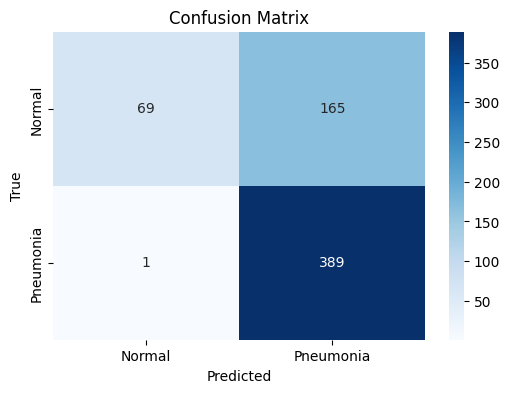

In [ ]:
import matplotlib.pyplot as plot
import seaborn as sns
class_labels = ['Normal', 'Pneumonia']

plot.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot = True, fmt='d', cmap='Blues', xticklabels = class_labels, yticklabels=class_labels)

plot.xlabel('Predicted')
plot.ylabel('True')
plot.title('Confusion Matrix')
plot.xticks(np.arange(NUM_CLASSES) + 0.5, class_labels)
plot.yticks(np.arange(NUM_CLASSES) + 0.5, class_labels)

plot.show()

In [ ]:
from tensorflow.keras.preprocessing import image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    return img_preprocessed

image_path = '/content/drive/MyDrive/chest_xray/chest_xray/test/NORMAL/IM-0011-0001-0002.jpeg'


preprocessed_image = preprocess_image(image_path)

prediction = model.predict(preprocessed_image)

class_label = np.argmax(prediction) #(0: 'Normal', 1: 'Pneumonia')

class_prob = prediction[0][class_label]

if class_label == 0:
    print("Predicted class: Normal")
else:
    print("Predicted class: Pneumonia")

print("Predicted probability: {:.2f}%".format(class_prob * 100))


1/1 [==============================] - 0s 62ms/step
Predicted class: Normal
Predicted probability: 100.00%


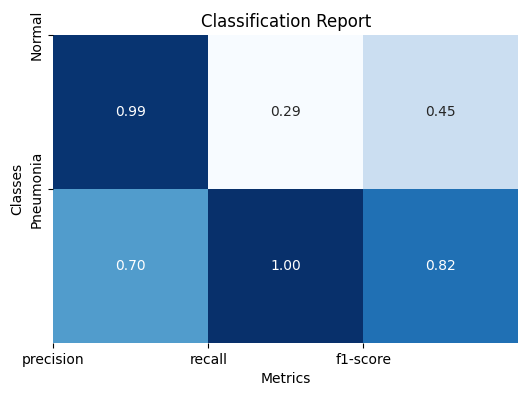

In [ ]:
import pandas as pd

report = classification_report(y_true, y_pred, target_names = ['Normal', 'Pneumonia'], output_dict = True)

metrics = ['precision', 'recall', 'f1-score']
heatmap_data = []
for label in class_labels:
    heatmap_data.append([report[label][metric] for metric in metrics])

plot.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='.2f', cbar=False)

plot.xlabel('Metrics')
plot.ylabel('Classes')
plot.title('Classification Report')
plot.xticks(np.arange(len(metrics)), metrics)
plot.yticks(np.arange(NUM_CLASSES), class_labels)

plot.show()